**<div style="text-align: right;">Uqaily, Raafay</div>**

<div style="text-align: right"> Student ID: 12225382 </div>

**FINM 33150 - Quantitative Trading Strategies**
<br>
Winter 2024

<h2><center> Homework 2: Spread Trading Simulation </center></h2>

<h2> 1. Introduction </h2>
<br>
This assignment required the extraction of data for the SVOL ETF, which is a rough proxy for the market's expected volatility and activity, and another pair of ETF's data from the QUOTEMEDIA\PRICES data table available through QUANDL. Then, a spread-reversion trading strategy, which checks a running estimate of the displacement between two related instruments, and makes bets that this displacement will decline whenever it gets large, had to be simulated. Finally, an analysis was conducted on how variations in: j, g, s, and &zeta; impacted the strategy's performance along with any significant relationship between the trading strategy, SVOL, and the Farma-French factors.

<h3> Import Statements </h3>

In [274]:
import os
import quandl
import zipfile
import datetime
import warnings
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

<h3> API Key </h3>

In [275]:
api_key = 'Enter API Key'

<h3> Helper Functions </h3>

In [276]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.path.expanduser('~'), "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key='6SrNeGHs_yp2pmDei8FV', **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    zip_file_path = grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    try:
        with zipfile.ZipFile(zip_file_path) as zip_file:
            print("Contents of the zip file:")
            print(zip_file.namelist())
    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file.")

    return pd.read_csv(zip_file_path)

In [277]:
def performance_summary(spread_data):
    """
    Returns the Performance Stats for a given spread.
    
    Inputs: 
        spread_data - DataFrame with Date index and Daily Values for a certain spread.
    
    Output:
        summary_stats - DataFrame with mean, volatility, and drawdown.
    """
    daily_returns = spread_data
    
    # Calculate statistics without annualizing
    summary_stats = pd.DataFrame()
    summary_stats['Mean'] = daily_returns.mean()
    summary_stats['Median'] = daily_returns.median()
    summary_stats['Volatility'] = daily_returns.std()    
    summary_stats['Skewness'] = daily_returns.skew()
    summary_stats['Excess Kurtosis'] = daily_returns.kurtosis()
    summary_stats['Min'] = daily_returns.min()
    summary_stats['Max'] = daily_returns.max()
    
    # Calculate drawdown
    wealth_index = 1000 * (1 + daily_returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    summary_stats['Max Drawdown'] = drawdowns.min()
    
    return summary_stats

<h2> 2. Data Extraction </h2>

<span style="color: rgb(0, 0, 128);"> The code below used the fetch_quandl_table function to pull data for the SVOL, IDU, and XLU ETF's from QUANDL. Since I then had technical chalenges with my laptop, I had to use a different computer half-way through and hence, simply transferred the extracted csv file from my laptop onto the new computer. The code then formats the date column in datetime and filters the table to only include data between 2nd Dec, 2021 and 15th Nov, 2023. The table is then sorted by date and the index is also set. Only the ticker, adj_close, and adj_volume columns are kept. </span>

In [278]:
t_prices = pd.read_csv('QUOTEMEDIA_PRICES_d8b055a3f3fe9fd32690561d10dbaa36.csv')

pd.to_datetime(t_prices.date, format='%Y-%m-%d')

start_date = '2021-12-02'
end_date = '2023-11-15'

t_prices = t_prices[(t_prices.date >= start_date) & (t_prices.date <= end_date)]
t_prices = t_prices.sort_values(by=['date'])
t_prices.set_index('date', inplace=True)

keep_cols = ['ticker', 'adj_close', 'adj_volume']
t_prices = t_prices[keep_cols]
t_prices

,ticker,adj_close,adj_volume
date,,,
2021-12-02,IDU,79.884378,31083.0
2021-12-02,XLU,63.191499,17523310.0
2021-12-02,SVOL,22.928100,70813.0
2021-12-03,IDU,80.385039,29978.0
2021-12-03,XLU,63.825971,21384053.0
...,...,...,...
2023-11-14,XLU,61.400108,28658779.0
2023-11-14,SVOL,22.730000,518056.0
2023-11-15,SVOL,22.790000,444877.0


<h3> SVOL ETF Data Table </h3>

<span style="color: rgb(0, 0, 128);"> The code below extracts data for the SVOL ETF from the t_prices dataframe and plots changes in price over time. </span>

In [391]:
t_svol = t_prices.loc[t_prices.ticker=='SVOL']
t_svol.rename(columns={'adj_close':'svol_adj_close','adj_volume':'svol_adj_volume'}, inplace=True)
t_svol.drop(columns=['ticker'], inplace=True)
t_svol['Date'] = t_svol.index
t_svol

,svol_adj_close,svol_adj_volume,Date
date,,,
2021-12-02,22.928100,70813.0,2021-12-02
2021-12-03,22.426795,135738.0,2021-12-03
2021-12-06,22.708230,60913.0,2021-12-06
2021-12-07,23.262303,19387.0,2021-12-07
2021-12-08,23.563878,18053.0,2021-12-08
...,...,...,...
2023-11-09,22.590000,404381.0,2023-11-09
2023-11-10,22.670000,270385.0,2023-11-10
2023-11-13,22.710000,242174.0,2023-11-13


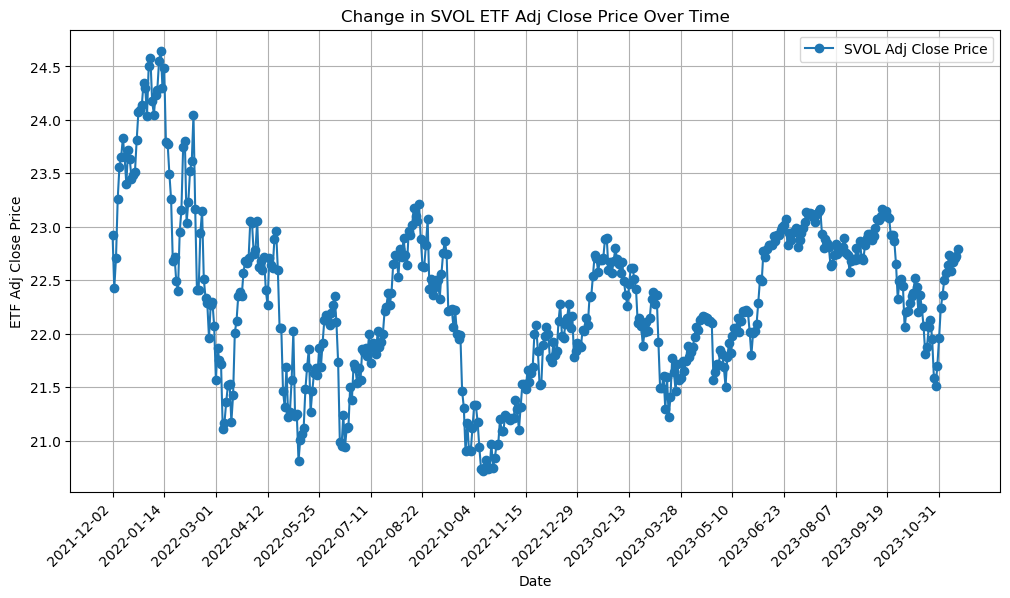

In [280]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_svol.index, t_svol['svol_adj_close'], label='SVOL Adj Close Price', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('ETF Adj Close Price')
plt.title('Change in SVOL ETF Adj Close Price Over Time')

# Show legend
plt.legend()

# Display every Nth date
N = 30
plt.xticks(t_svol.index[::N], rotation=45, ha='right')

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> The Simplify Volatility Premium ETF (SVOL) is an actively managed exchange-traded fund that aims to profit from periods of low volatility, and its price should generally rise when the VIX falls and fall when the VIX rises. During this period, SVOL displayed a relatively downward trend, reflecting a predominantly volatile market. </span>

<span style="color: rgb(255,69,0);"> Key observations: </span>

<span style="color: rgb(255,69,0);"> December 2021 - March 2022: SVOL initially started strong, reaching a peak in January 2022. However, a surge in the VIX during this period due to concerns about rising inflation and interest rates caused SVOL to decline sharply. </span>
<br>
<br>
<span style="color: rgb(255,69,0);"> July 2022 - November 2023: There were intermittent periods of both rises and falls, but the overall trend remained bearish. </span>

<h3> IDU ETF Data (X) </h3>

<span style="color: rgb(0, 0, 128);"> The code below extracts data for the IDU ETF (X) from the t_prices dataframe, calculates the adj_dollar_volume which is the adj_close price times the adj_volume on any given day. It then computes a 15-trading-day trailing median of the adj_dollar_volume over the sample period. As mentioned in class, this is done under the assumption that the IDU ETF (X) is the less liquid of the two ETFs being tracked. </span>

In [281]:
t_idu = t_prices.loc[t_prices.ticker=='IDU']
t_idu.rename(columns={'adj_close':'idu_adj_close','adj_volume':'idu_adj_volume'}, inplace=True)
t_idu['idu_adj_dollar_volume'] = t_idu['idu_adj_close'] * t_idu['idu_adj_volume']
t_idu['idu_trailing_median_adj_dollar_volume'] = t_idu['idu_adj_dollar_volume'].rolling(window=15).median()
t_idu.drop(columns=['ticker'], inplace=True)
t_idu

,idu_adj_close,idu_adj_volume,idu_adj_dollar_volume,idu_trailing_median_adj_dollar_volume
date,,,,
2021-12-02,79.884378,31083.0,2.483046e+06,NaN
2021-12-03,80.385039,29978.0,2.409783e+06,NaN
2021-12-06,81.636693,46904.0,3.829087e+06,NaN
2021-12-07,82.243263,39473.0,3.246388e+06,NaN
2021-12-08,82.224007,40490.0,3.329250e+06,NaN
...,...,...,...,...
2023-11-09,74.741944,49204.0,3.677603e+06,5.168324e+06
2023-11-10,75.051614,44249.0,3.320959e+06,5.168324e+06
2023-11-13,74.316879,40562.0,3.014441e+06,5.120340e+06


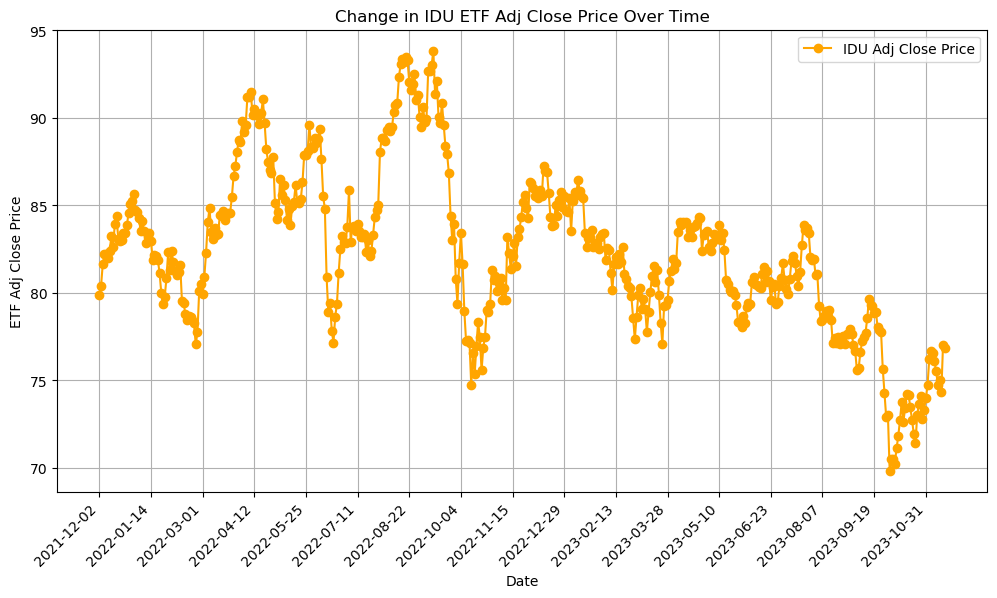

In [282]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_idu.index, t_idu['idu_adj_close'], label='IDU Adj Close Price', marker='o', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('ETF Adj Close Price')
plt.title('Change in IDU ETF Adj Close Price Over Time')

# Show legend
plt.legend()

# Display every Nth date
N = 30
plt.xticks(t_svol.index[::N], rotation=45, ha='right')

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> The iShares International Developed Value ETF (IDU) is a passively managed exchange-traded fund that tracks the performance of the FTSE Developed Value Capped Index. This index comprises large and mid-cap companies from developed countries outside of the United States, with a focus on value stocks. In simpler terms, IDU aims to provide exposure to established, undervalued companies in developed international markets. Similarly to SVOL, IDU's price during this period was largely influenced by broader market forces, particularly concerns about global economic growth and rising interest rates. </span>

<span style="color: rgb(255,69,0);"> Key observations: </span>

<span style="color: rgb(255,69,0);"> December 2021 - March 2022: IDU started strong, however, the onset of the war in Ukraine and subsequent market volatility caused a decline by March 2022. </span>
<br>
<br>
<span style="color: rgb(255,69,0);"> April 2022 - July 2022: As concerns about inflation rose and central banks signaled tighter monetary policy, IDU continued to fall, reaching a low in July 2022. </span>
<br>
<br>
<span style="color: rgb(255,69,0);"> August 2022 - November 2023: There were some ups and downs, but the overall trend remained relatively flat initally with a gradual fall towards August 2023 onwards. </span>

<h3> XLU ETF Data (Y) </h3>

<span style="color: rgb(0, 0, 128);"> The code below extracts data from the t_prices dataframe for the XLU ETF (Y) and plots changes in price over time. </span>

In [283]:
t_xlu = t_prices.loc[t_prices.ticker=='XLU']
t_xlu.rename(columns={'adj_close':'xlu_adj_close','adj_volume':'xlu_adj_volume'}, inplace=True)
t_xlu.drop(columns=['ticker'], inplace=True)
t_xlu

,xlu_adj_close,xlu_adj_volume
date,,
2021-12-02,63.191499,17523310.0
2021-12-03,63.825971,21384053.0
2021-12-06,64.801353,23610544.0
2021-12-07,65.284309,10892278.0
2021-12-08,65.218021,12996041.0
...,...,...
2023-11-09,59.438633,16097520.0
2023-11-10,59.755640,14015090.0
2023-11-13,59.042376,15579238.0


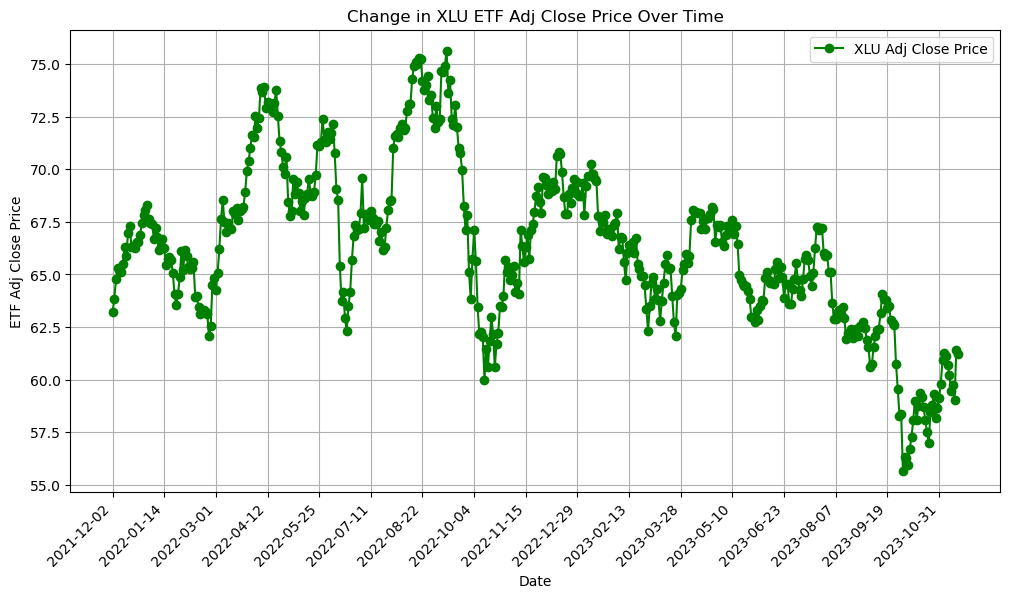

In [284]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_xlu.index, t_xlu['xlu_adj_close'], label='XLU Adj Close Price', marker='o', color='green')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('ETF Adj Close Price')
plt.title('Change in XLU ETF Adj Close Price Over Time')

# Show legend
plt.legend()

# Display every Nth date
N = 30
plt.xticks(t_svol.index[::N], rotation=45, ha='right')

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> The iShares Utilities ETF (XLU) tracks the Dow Jones Utility Average, which comprises leading U.S. utility companies engaged in the generation, transmission, and distribution of electricity, natural gas, and water. XLU aims to provide investors with exposure to the relatively stable and defensive utilities sector. </span>

<span style="color: rgb(255,69,0);"> Key observations: </span>

<span style="color: rgb(255,69,0);"> December 2021 - March 2022: XLU initially followed the broader market upward, reaching a peak in February 2022. However, the onset of market volatility caused a slight dip by March 2022. </span>
<br>
<br>
<span style="color: rgb(255,69,0);"> While concerns about inflation and rising interest rates impacted most equities, XLU's price held relatively steady. This can be attributed to the perceived stability and income-generating nature of utilities during uncertain economic times. </span>

<h3> Farma-French Factor Returns Data </h3>

<span style="color: rgb(0, 0, 128);"> The code below extracts Farma-French factor returns data from a csv file obtained from Ken French's website. It then formats the date column in datetime and filters the table to only include data between 2nd Dec, 2021 and 15th Nov, 2023. The table is then sorted by date and the index is also set. Additionally, trading holidays were excluded from the dataframe to have the same number of data points as the ETF data tables. </span>

In [386]:
t_fff = pd.read_csv('Developed_3_Factors_Daily.csv')

t_fff['date'] = pd.to_datetime(t_fff['date'], format='%Y%m%d')

start_date = '2021-12-02'
end_date = '2023-11-15'

t_fff = t_fff[(t_fff.date >= start_date) & (t_fff.date <= end_date)]
t_fff = t_fff.sort_values(by=['date'])
t_fff.set_index('date', inplace=True)
t_fff['Date'] = t_fff.index

trading_holidays = ['2021-12-24', '2022-01-17', '2022-02-21', '2022-04-15', '2022-05-30', '2022-06-20', '2022-07-04', \
                   '2022-09-05', '2022-11-24', '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20', '2023-04-07', \
                   '2023-05-29', '2023-06-19', '2023-07-04', '2023-09-04']
condition = ~t_fff.index.isin(trading_holidays)
t_fff = t_fff[condition]
t_fff

,Mkt-RF,SMB,HML,RF,Date
date,,,,,
2021-12-02,0.71,-0.79,1.53,0.00,2021-12-02
2021-12-03,-0.76,-0.04,0.94,0.00,2021-12-03
2021-12-06,0.90,-0.61,1.07,0.00,2021-12-06
2021-12-07,2.19,0.25,-1.49,0.00,2021-12-07
2021-12-08,0.39,0.28,-0.63,0.00,2021-12-08
...,...,...,...,...,...
2023-11-09,-0.40,0.00,0.21,0.02,2023-11-09
2023-11-10,0.76,-0.72,0.01,0.02,2023-11-10
2023-11-13,0.13,-0.14,0.13,0.02,2023-11-13


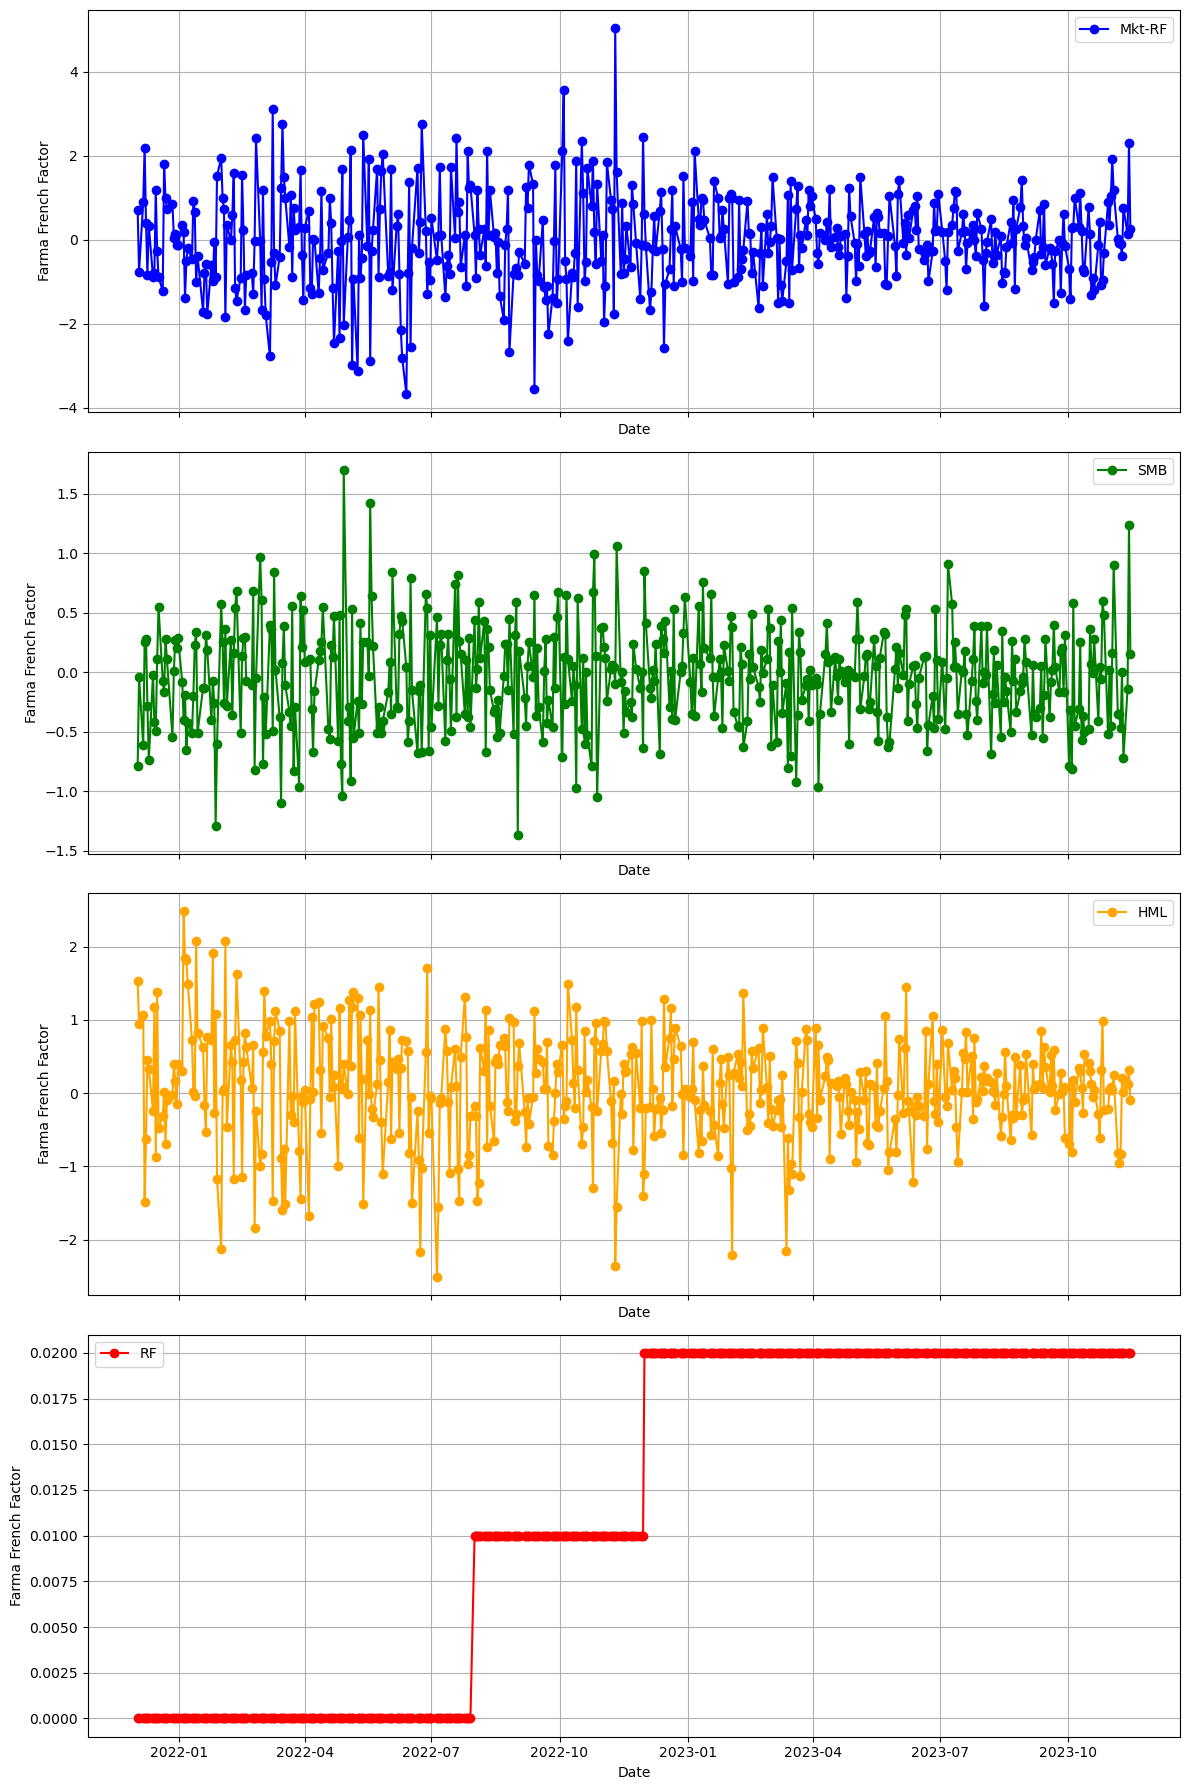

In [286]:
fig, axs = plt.subplots(4, 1, figsize=(12, 18), sharex=True)

# Plot each Farma French factor in a separate subplot with different colors
axs[0].plot(t_fff.index, t_fff['Mkt-RF'], label='Mkt-RF', marker='o', color='blue')
axs[1].plot(t_fff.index, t_fff['SMB'], label='SMB', marker='o', color='green')
axs[2].plot(t_fff.index, t_fff['HML'], label='HML', marker='o', color='orange')
axs[3].plot(t_fff.index, t_fff['RF'], label='RF', marker='o', color='red')

# Adjustments for each subplot
for ax in axs:
    ax.set_xlabel('Date')
    ax.set_ylabel('Farma French Factor')
    ax.legend()
    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> The Fama-French Three-Factor Model, developed by Eugene Fama and Kenneth French, expands upon the Capital Asset Pricing Model (CAPM) to explain asset returns by incorporating two additional factors beyond market risk. </span>

<span style="color: rgb(255,69,0);"> Mkt-RF: This represents the market risk premium, which is the difference between the expected return of the overall market and the risk-free rate. Essentially, it captures the compensation investors receive for taking on the additional risk of holding stocks compared to risk-free assets like government bonds. </span>
<br>
<br>
<span style="color: rgb(255,69,0);"> SMB: This refers to the size factor, also known as small minus big. It captures the historical tendency of small-cap stocks to outperform large-cap stocks over the long term. </span>
<br>
<br>
<span style="color: rgb(255,69,0);"> HML: This stands for high minus low, also known as the value factor. It captures the historical tendency of value stocks (with high book-to-market ratios) to outperform growth stocks (with low book-to-market ratios) over the long term. </span>
<br>
<br>
<span style="color: rgb(255,69,0);"> RF: This is the risk-free rate, typically represented by the return on government bonds with negligible risk of default. It serves as the baseline for calculating the risk premium and the other factors' contributions to a portfolio's return. </span>

<h3> Spread Data Table </h3>

<span style="color: rgb(0, 0, 128);"> The code below creates a table for the spread between IDU and XLU ETFs calculated as IDU Return minus XLU Return, along with computing the daily dollar amount that can be traded for each ETF, which was the trailing 15-day median dollar volume of IDU (X) divided by 100. The change in adj close price, the change in adj close volumes, and the difference spread for both ETF's are all graphed separately over the entire time horizon. </span>

In [326]:
t_spread = pd.DataFrame()
t_spread['IDU Close Price'] = t_idu['idu_adj_close']
t_spread['IDU Returns'] = t_spread['IDU Close Price'].pct_change()
t_spread['XLU Close Price'] = t_xlu['xlu_adj_close']
t_spread['XLU Returns'] = t_spread['XLU Close Price'].pct_change()
t_spread['Dollar Amount Trading Limit'] = t_idu['idu_trailing_median_adj_dollar_volume']/100
t_spread['Spread'] = t_spread['IDU Returns'] - t_spread['XLU Returns']

t_spread["Date"] = t_spread.index
column_order = ['Date', 'IDU Close Price', 'IDU Returns', 'XLU Close Price', 'XLU Returns', 'Dollar Amount Trading Limit', 'Spread']
t_spread = t_spread[column_order]
t_spread

,Date,IDU Close Price,IDU Returns,XLU Close Price,XLU Returns,Dollar Amount Trading Limit,Spread
date,,,,,,,
2021-12-02,2021-12-02,79.884378,NaN,63.191499,NaN,NaN,NaN
2021-12-03,2021-12-03,80.385039,0.006267,63.825971,0.010040,NaN,-0.003773
2021-12-06,2021-12-06,81.636693,0.015571,64.801353,0.015282,NaN,0.000289
2021-12-07,2021-12-07,82.243263,0.007430,65.284309,0.007453,NaN,-0.000023
2021-12-08,2021-12-08,82.224007,-0.000234,65.218021,-0.001015,NaN,0.000781
...,...,...,...,...,...,...,...
2023-11-09,2023-11-09,74.741944,-0.010529,59.438633,-0.013158,51683.241174,0.002629
2023-11-10,2023-11-10,75.051614,0.004143,59.755640,0.005333,51683.241174,-0.001190
2023-11-13,2023-11-13,74.316879,-0.009790,59.042376,-0.011936,51203.403179,0.002147


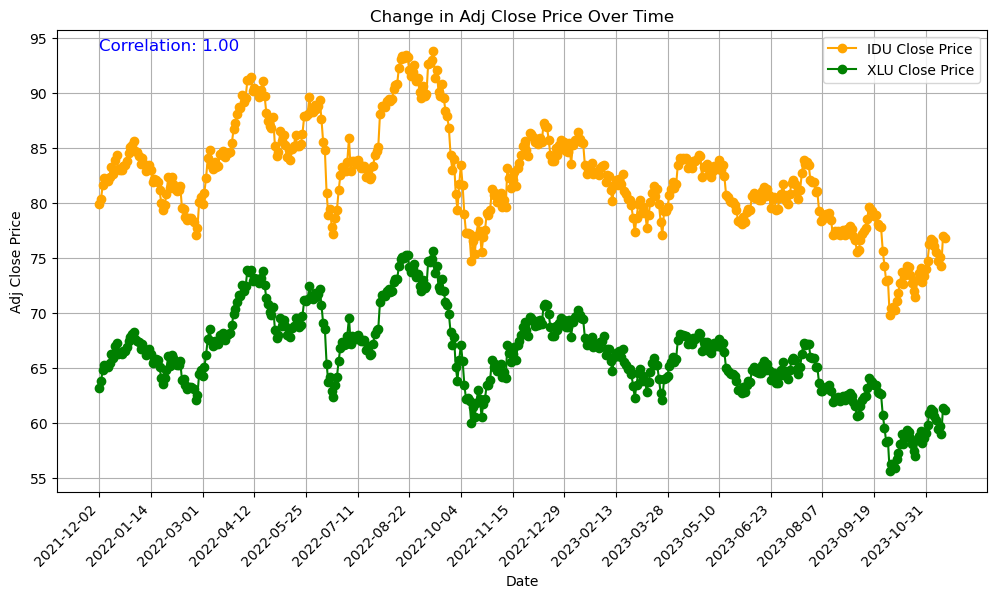

In [288]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_spread.index, t_spread['IDU Close Price'], label='IDU Close Price', marker='o', color='orange')
plt.plot(t_spread.index, t_spread['XLU Close Price'], label='XLU Close Price', marker='o', color='green')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('Change in Adj Close Price Over Time')

# Show legend
plt.legend()

# Display every Nth date
N = 30
plt.xticks(t_svol.index[::N], rotation=45, ha='right')

# Adding grid lines
plt.grid(True)

# Calculate correlation coefficient
correlation_coefficient = t_spread['IDU Close Price'].corr(t_spread['XLU Close Price'])

# Add text with correlation coefficient
plt.text(t_spread.index[0], max(t_spread['IDU Close Price']), f'Correlation: {correlation_coefficient:.2f}', fontsize=12, color='blue')

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, both IDU and XLU adjusted close prices seem to move together over the two year period. There also seems to be perfect correlation as indicated by a correlation coefficient of 1.0  </span>

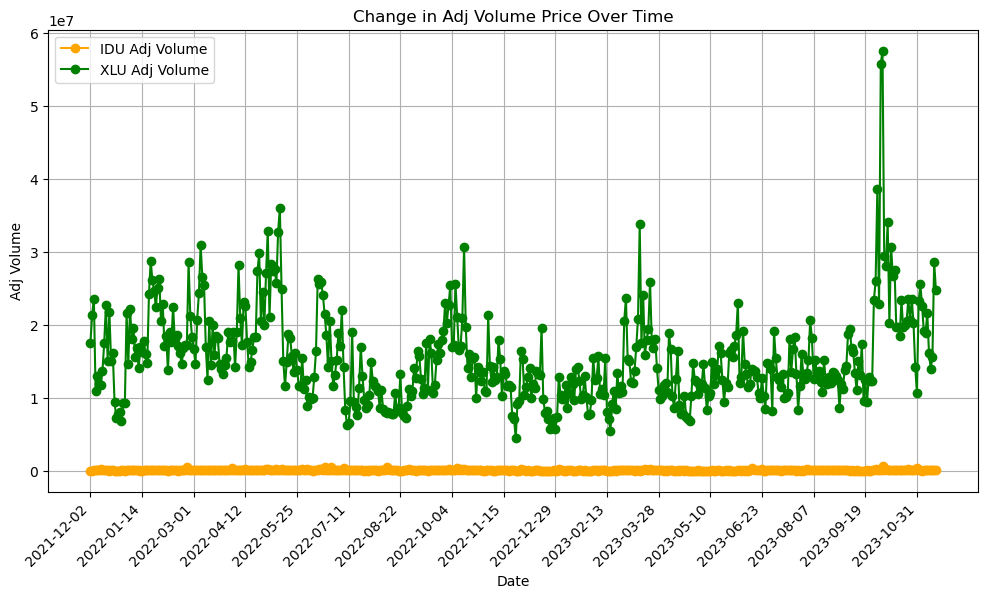

In [289]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_idu.index, t_idu['idu_adj_volume'], label='IDU Adj Volume', marker='o', color='orange')
plt.plot(t_xlu.index, t_xlu['xlu_adj_volume'], label='XLU Adj Volume', marker='o', color='green')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Adj Volume')
plt.title('Change in Adj Volume Price Over Time')

# Show legend
plt.legend()

# Display every Nth date
N = 30
plt.xticks(t_svol.index[::N], rotation=45, ha='right')

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, we can clearly see that IDU has a much lower adj volume than XLU. Hence, it makes sense to limit our trades to 1% of IDU's daily dollar volume to avoid manipulating the market.  </span>

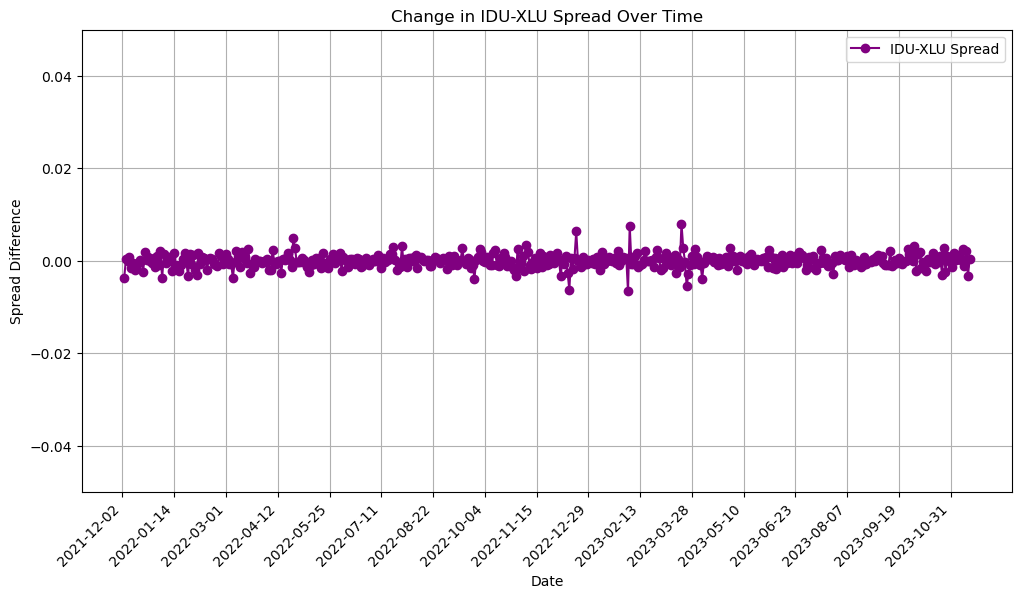

In [290]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_spread.index, t_spread['Spread'], label='IDU-XLU Spread', marker='o', color='purple')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Spread Difference')
plt.title('Change in IDU-XLU Spread Over Time')

# Show legend
plt.legend()

# Display every Nth date
N = 30
plt.xticks(t_svol.index[::N], rotation=45, ha='right')
plt.ylim(-0.05, 0.05)

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, we can clearly see that the spread difference between IDU and XLU returns is so small, nearly zero for the entire duration we observe both ETF's. (Make note that I have intentionally set the y axis limits to be wider so the excessive noise with smaller limits doesn't convince us otherwise about how closely both ETF prices change).  </span>

In [291]:
t_spreads = pd.DataFrame()
t_spreads['Spread'] = t_spread['Spread']
performance_summary(t_spreads)

,Mean,Median,Volatility,Skewness,Excess Kurtosis,Min,Max,Max Drawdown
Spread,-0.000021,0.000014,0.001475,0.246282,5.064383,-0.00661,0.008049,-0.028606


<span style="color: rgb(255,69,0);"> As shown above, the spread mean was -0.000021, the meadian was 0.000014, standard deviation was 0.001475, skewness (measures asymmetery) was 0.25, excess kurtosis (measures tail-heaviness of a distribution's peak) was -5.06.  </span>

<span style="color: rgb(255,69,0);"> Some Possible Macroeconomic Explanations for the given trends include: </span>
<br>
<br>
<span style="color: rgb(255,69,0);"> Rising interest rates: The prospect of tighter monetary policy by central banks also played a role. Value stocks, like those in IDU, can be more sensitive to rising interest rates compared to growth stocks or defensive sectors like utilities (XLU). This could have contributed to the wider spread observed in certain periods. </span>
<br>
<br>
<span style="color: rgb(255,69,0);"> Energy prices: Fluctuations in energy prices, particularly natural gas, also influenced the performance of both ETFs. XLU's utility holdings benefited from rising energy costs to some extent, while IDU's exposure to various sectors could have been more susceptible to price movements depending on their energy consumption. </span>

<h2> 3. Trading Strategy Simulation </h2>

<h3> Inner and Outer Bounds Computation

<span style="color: rgb(0, 0, 128);"> The code below plots the Boolinger Bands for the difference spread between IDU and XLU returns. Bollinger Bands are a technical analysis tool used to analyze price volatility and potential trading opportunities in financial markets. They are plotted as envelopes above and below a moving average, visually representing the price's "normal" range of fluctuation. Price near the upper band suggests the price is currently overbought, potentially indicating a sell signal. Price near the lower band suggests the price is oversold, potentially indicating a buy signal. I will be using the average of the upper and lower bands for my g values. Additionally, my j values will be discounted g values by 75%. The figure below gives a visual representation of my choice of entry and exit points. </span>

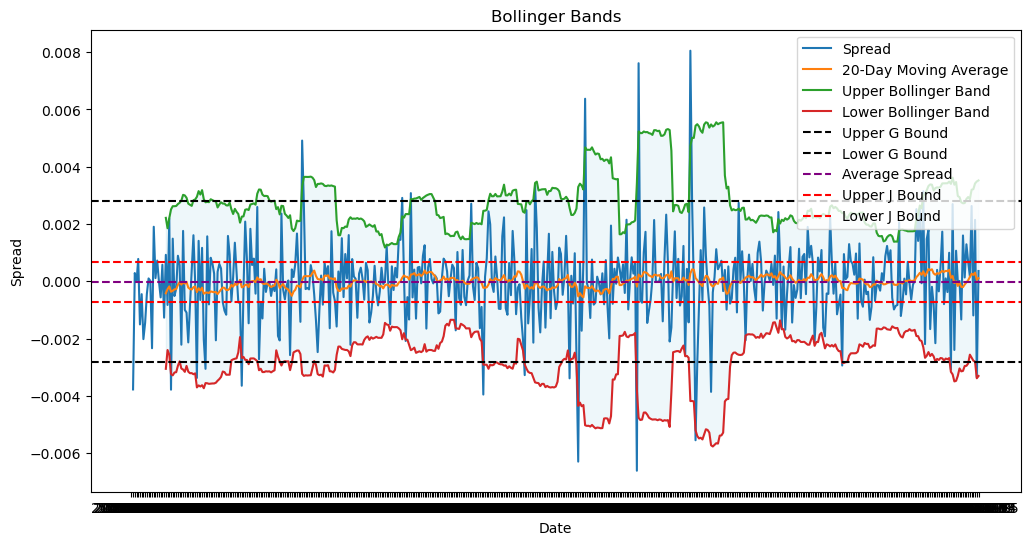

In [292]:
# Load spread data
data = t_spread.copy()

# Calculate the 20-day moving average
data['MA20'] = data['Spread'].rolling(window=20).mean()

# Calculate the standard deviation
data['SD20'] = data['Spread'].rolling(window=20).std()

# Calculate the upper and lower Bollinger Bands
data['UpperBand'] = data['MA20'] + 2 * data['SD20']
data['LowerBand'] = data['MA20'] - 2 * data['SD20']

# Calculate average spread
avg_spread = data['Spread'].mean()

# Calculate upper and lower g bounds
upper_g_bound = data['UpperBand'].mean()
lower_g_bound = data['LowerBand'].mean()

# Calculate upper and lower j bounds
upper_j_bound = (upper_g_bound - avg_spread)*0.25 + avg_spread
lower_j_bound = avg_spread - (avg_spread - lower_g_bound)*0.25

# Plot the data and Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Spread'], label='Spread')
plt.plot(data.index, data['MA20'], label='20-Day Moving Average')
plt.plot(data.index, data['UpperBand'], label='Upper Bollinger Band')
plt.plot(data.index, data['LowerBand'], label='Lower Bollinger Band')

# Add lines for j and g upper and lower bounds
plt.axhline(y=upper_g_bound, color='black', linestyle='--', label='Upper G Bound')
plt.axhline(y=lower_g_bound, color='black', linestyle='--', label='Lower G Bound')
plt.axhline(y=avg_spread, color='purple', linestyle='--', label='Average Spread')
plt.axhline(y=upper_j_bound, color='red', linestyle='--', label='Upper J Bound')
plt.axhline(y=lower_j_bound, color='red', linestyle='--', label='Lower J Bound')

plt.fill_between(data.index, data['UpperBand'], data['LowerBand'], color='lightblue', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, we can see that boolinger bands do a great job in identifying good buy and sell signals based on the 20-day moving average in spread difference.  </span>

In [293]:
g_value = upper_g_bound - avg_spread
g_value

0.0028229844362113008

In [294]:
j_value = upper_j_bound - avg_spread
j_value

0.0007057461090528252

<span style="color: rgb(255,69,0);"> As calculated above, the g value was decided to be +/- 0.0028 (average of 2 standard deviations away from 20-day moving average) while the j value was decided to be +/- 0.00071 (25% of g) from the average spread value of -0.000021. </span>

<h2> Mean-Reversion Strategy Backtesting </h2>

<span style="color: rgb(0, 0, 128);"> I will now start the implementation of my trading strategy. Firstly, I will modify my existing dataframe to only include dates after 1st January, 2022 and make sure my date columns are in datetime format. </span>

In [295]:
start_date = '2022-01-01'

t_spread['Date'] = pd.to_datetime(t_spread['Date'])
t_spread.index = pd.to_datetime(t_spread.index)

t_spread = t_spread[(t_spread.Date >= start_date)]

t_spread

,Date,IDU Close Price,IDU Returns,XLU Close Price,XLU Returns,Dollar Amount Trading Limit,Spread
date,,,,,,,
2022-01-03,2022-01-03,84.725772,-0.010743,67.638593,-0.009919,35409.904666,-0.000824
2022-01-04,2022-01-04,84.648291,-0.000914,67.428624,-0.003104,35409.904666,0.002190
2022-01-05,2022-01-05,84.280255,-0.004348,67.390448,-0.000566,35409.904666,-0.003782
2022-01-06,2022-01-06,83.534498,-0.008849,66.693733,-0.010338,35409.904666,0.001490
2022-01-07,2022-01-07,84.125292,0.007072,67.199567,0.007584,35409.904666,-0.000512
...,...,...,...,...,...,...,...
2023-11-09,2023-11-09,74.741944,-0.010529,59.438633,-0.013158,51683.241174,0.002629
2023-11-10,2023-11-10,75.051614,0.004143,59.755640,0.005333,51683.241174,-0.001190
2023-11-13,2023-11-13,74.316879,-0.009790,59.042376,-0.011936,51203.403179,0.002147


<span style="color: rgb(0, 0, 128);"> The code below first plots the change in daily dollar amount trading limit over time to identify the max and then sets my capital on position entry as 2 times the max daily dollar amount trading limit since I will be trading equal dollar values of both IDU and XLU every day. </span>

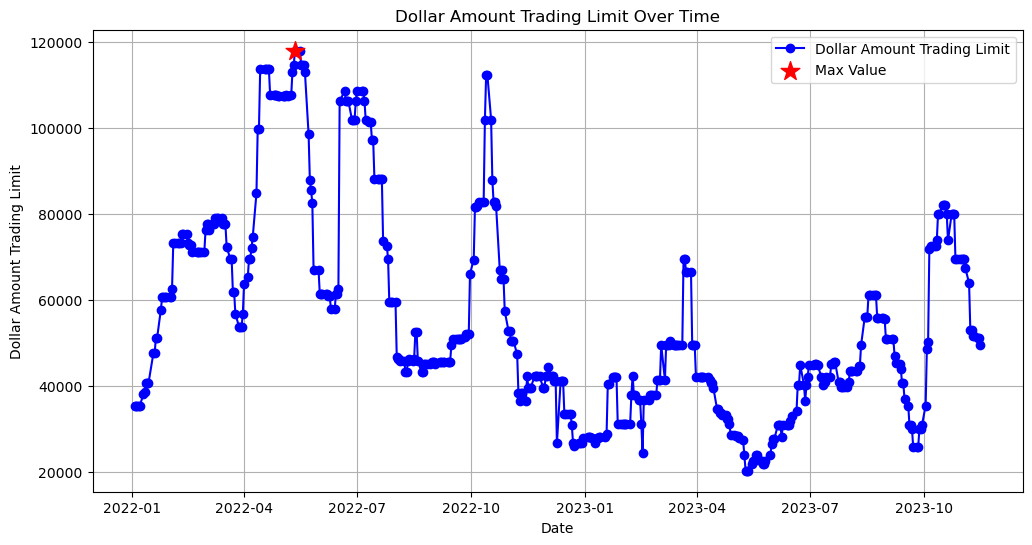

In [314]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting the line
plt.plot(t_spread.index, t_spread['Dollar Amount Trading Limit'], label='Dollar Amount Trading Limit', color='blue', marker='o')

# Identify max value
max_value = t_spread['Dollar Amount Trading Limit'].max()
max_index = t_spread['Dollar Amount Trading Limit'].idxmax()

# Plot a star on the max value
plt.scatter(max_index, max_value, color='red', marker='*', s=200, label='Max Value', zorder=5)  # Increased zorder

# Adding labels, title, legend, etc.
plt.xlabel('Date')
plt.ylabel('Dollar Amount Trading Limit')
plt.title('Dollar Amount Trading Limit Over Time')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [303]:
capital = np.max(t_spread['Dollar Amount Trading Limit']) * 2
capital

235732.3421330138

<span style="color: rgb(0, 0, 128);"> The code below creates temporary variables to help track my trading strategy. open_position tells me if I currently have an open position or not, IDU_position and XLU_position tell me the temporary positions I hold in each ETF if I have an open trade, temp_position_type indicates whether I am long or short the spread, and stop_loss_value is my chosen value to implement stop-loss. I also have a variable current_month which will be used to avoid trading for the remainder of a month if stop-loss becomes true at any point. </span>

In [305]:
t_spread_trade = t_spread
open_position = False
IDU_position = 0
XLU_position = 0
IDU_adj_close = 0
XLU_adj_close = 0
position_type = 0
cumulative_PNL = 0
trade_backtesting = []
stop_loss_value = 0.05
current_month = row['Date'].month
current_month = None

<span style="color: rgb(0, 0, 128);"> The code below starts with creating arrays for different g, j, and trading cost values. My g and j values initially came from the boolinger band bound analysis done above, with additional values to determine how they change the trading strategy's performance. Trading cost multiplier values were suggested in the assignment. My code essentially loops through each different g/j/trading_cost_multiplier value in order to loop through my entire t_spread_trade dataframe. I first check if there already is an open position. If there is, I check if stop-loss value is exceeded or my spread value is less than j if I am shorting the spread (or greater than -j if buying the spread) to exit out of the trade. If none of these conditions are met, I move to the next row. If I don't have an open position, and if the spread is greater than g if I am shorting the spread (or less than g if I am buying the spread), I will enter into a new trade. During this entire time, I am tracking my PNL, cumulative_PNL, and Return on capital. Additionally, I also check to make sure that I liquidate all positions at the end of the trading period. My code also ensures that I only do 1 trade a day by introducing a variable "Trade Executed". If that variable is true, no other trade takes place for that given day. Finally, I track my cumulative PNL for all variations of g/j/trading_cost_multiplier values and report results in a dataframe sorted in descending order. </span>

In [351]:
# Define the ranges for g, j, and trading_cost_multiplier values
g_values = [0.0008, 0.0018, 0.0028, 0.0038, 0.0048]  # Add more values as needed
j_values = [0.00005, 0.0001, 0.0002, 0.0007, 0.00012]  # Add more values as needed
trading_cost_multiplier_values = [0, 0.00001]  # Add more values as needed

results = []

# Iterate over combinations of g, j, and trading_cost_multiplier
for g in g_values:
    for j in j_values:
        for trading_cost_multiplier in trading_cost_multiplier_values:
            # Initialize variables for each combination
            open_position, IDU_adj_close, XLU_adj_close, IDU_position, XLU_position, cumulative_PNL = reset_monthly_variables()
            trade_backtesting = []

            # Iterate through rows in t_spread_trade DataFrame
            for idx, row in t_spread_trade.iterrows():
                # Check if the month has changed
                if current_month != row['Date'].month:
                    open_position, IDU_adj_close, XLU_adj_close, IDU_position, XLU_position, cumulative_PNL = reset_monthly_variables()
                    current_month = row['Date'].month

                # Execute logic for open positions
                if open_position:
                    if not row['Exit Trade'] and not row['Trade Executed']:
                        row['IDU Position'], row['XLU Position'], row['Mark-to-Market'] = IDU_position, XLU_position, \
                                                                                           calculate_mark_to_market(IDU_position,
                                                                                                                    IDU_adj_close,
                                                                                                                    XLU_position,
                                                                                                                    XLU_adj_close,
                                                                                                                    row)

                        if row['Mark-to-Market'] > stop_loss_value * (abs(IDU_position * IDU_adj_close) +
                                                                       abs(XLU_position * XLU_adj_close)):
                            row['Stop-Loss'] = True
                        elif (-temp_position_type * row['Spread']) <= j:
                            row['Exit Trade'] = True

                        if row['Stop-Loss'] or row['Exit Trade']:
                            IDU_adj_close, XLU_adj_close, IDU_position, XLU_position, open_position = \
                                adjust_pnl_and_reset_variables(IDU_position, IDU_adj_close, XLU_position, XLU_adj_close, open_position, row)

                # Execute logic for no open positions and meeting spread condition
                if not open_position and (abs(row['Spread']) >= g):
                    if not row['Enter Trade'] and not row['Trade Executed']:
                        temp_position_type = 1 if row['Spread'] <= 0 else -1
                        IDU_adj_close, XLU_adj_close, IDU_position, XLU_position = \
                            execute_trade(IDU_adj_close, XLU_adj_close, temp_position_type, row)
                        open_position = True

                # Update cumulative PNL and return on capital
                row['Cumulative PNL'] = row['PNL'] + cumulative_PNL
                cumulative_PNL = row['Cumulative PNL']
                row['Return on Capital'] = cumulative_PNL / capital

                # Append the current row to trade_backtesting list if trade-related events occur
                if row['Enter Trade'] or row['Stop-Loss'] or row['Exit Trade']:
                    trade_backtesting.append(row)

            # Check if there's an open position at the last date and close it
            if open_position:
                last_row = t_spread_trade.iloc[-1]
                last_row['IDU Position'], last_row['XLU Position'], last_row['Mark-to-Market'] = IDU_position, XLU_position, \
                                                                                                 calculate_mark_to_market(IDU_position,
                                                                                                                          IDU_adj_close,
                                                                                                                          XLU_position,
                                                                                                                          XLU_adj_close,
                                                                                                                          last_row)
                if last_row['Mark-to-Market'] > stop_loss_value * (abs(IDU_position) * IDU_adj_close +
                                                                    abs(XLU_position) * XLU_adj_close):
                    last_row['Stop-Loss'] = True
                elif (-temp_position_type * last_row['Spread']) < j:
                    last_row['Exit Trade'] = True

                # Adjust PNL and reset variables if stop-loss or exit trade occurs at the last date
                if last_row['Stop-Loss'] or last_row['Exit Trade']:
                    IDU_adj_close, XLU_adj_close, IDU_position, XLU_position, open_position = \
                        adjust_pnl_and_reset_variables(IDU_position, IDU_adj_close, XLU_position, XLU_adj_close, open_position, last_row)

            # Calculate the average cumulative PNL for the current combination
            avg_cumulative_pnl = sum([row['Cumulative PNL'] for row in trade_backtesting]) / len(trade_backtesting)

            # Save the results for the current combination of g, j, and trading_cost_multiplier
            result_entry = {'g': g, 'j': j, 'trading_cost_multiplier': trading_cost_multiplier, 'Cumulative PNL': avg_cumulative_pnl, 'Return on Capital': row['Return on Capital']}
            results.append(result_entry)

# Convert the results list of dictionaries into a DataFrame and sort by Cumulative PNL in descending order
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Cumulative PNL', ascending=False)

## 4. Data Analysis

### Varying g, j, and trading cost multiplier

In [352]:
# Display the results DataFrame
results_df

,g,j,trading_cost_multiplier,Cumulative PNL,Return on Capital
0,0.0008,0.00005,0.00000,98.610693,0.000585
1,0.0008,0.00005,0.00001,95.563034,0.000570
8,0.0008,0.00012,0.00000,91.880407,0.000585
2,0.0008,0.00010,0.00000,90.219606,0.000585
9,0.0008,0.00012,0.00001,88.791734,0.000570
3,0.0008,0.00010,0.00001,87.146016,0.000570
4,0.0008,0.00020,0.00000,86.004772,0.001235
5,0.0008,0.00020,0.00001,82.907536,0.001216
6,0.0008,0.00070,0.00000,58.110031,0.001281
7,0.0008,0.00070,0.00001,54.833153,0.001262


<span style="color: rgb(255,69,0);"> As shown above, we can see that the best spread trading strategy involved a g of 0.0008, a j value of 0.00005 and no trading costs. This makes sense as smaller bounds will enable us to trade more frequntly while no trading costs will not hinder our profit-and-loss to suffer due to transaction costs. Additionally, We see that all else constant, as our g value increases, our strategy performs more poorly. Similarly, as our j value increaes, our strategy performs more poorly. And lastly, holding g and j values constant, increasing trading cost multiplier values also makes our trading strategy perform more poorly. Overall, I expected such results as the instructor had mentioned in class that we shouldn't be expecting very high PNLs for this particular assignment. </span>

<span style="color: rgb(0, 0, 128);"> The code below graphs the spread, along with when I entered/exited trades for the best performing strategy based on the results dataframe as shown above. </span>

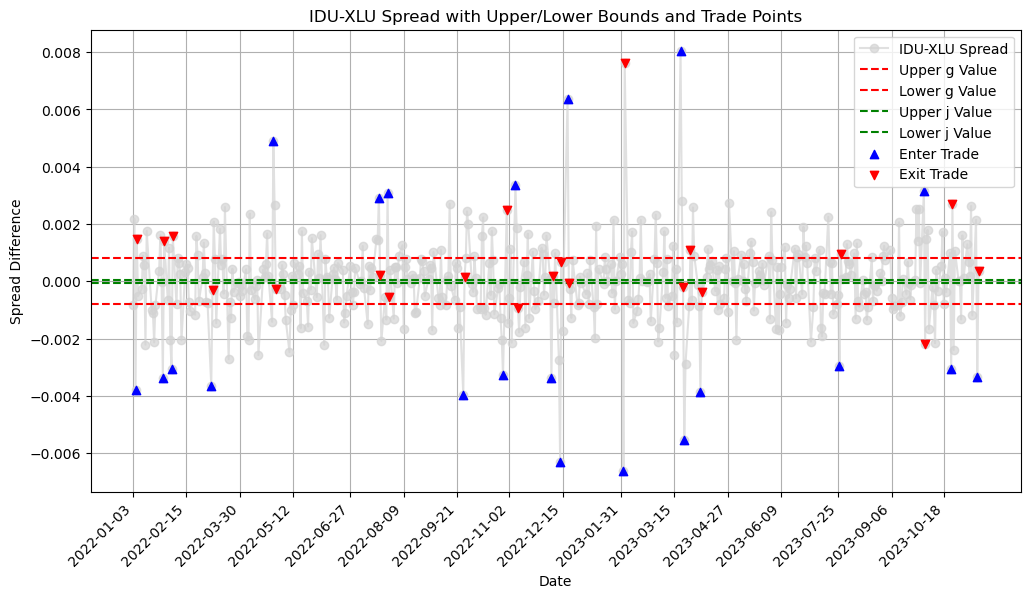

In [353]:
# Find the row with the maximum 'Average Cumulative PNL'
best_row = results_df.loc[results_df['Cumulative PNL'].idxmax()]

# Extract the best-performing values
best_g = best_row['g']
best_j = best_row['j']
best_trading_cost_multiplier = best_row['trading_cost_multiplier']

# Filter the results_df DataFrame for the best-performing values
best_results = results_df[(results_df['g'] == best_g) & (results_df['j'] == best_j) & (results_df['trading_cost_multiplier'] == best_trading_cost_multiplier)]

# Plotting
plt.figure(figsize=(12, 6))

# Plot the IDU-XLU Spread with lighter color
plt.plot(t_spread_trade.index, t_spread_trade['Spread'], label='IDU-XLU Spread', marker='o', color='lightgrey', alpha=0.7)

# Plot upper and lower g/j bounds
plt.axhline(best_g, color='r', linestyle='--', label='Upper g Value')
plt.axhline(-best_g, color='r', linestyle='--', label='Lower g Value')
plt.axhline(best_j, color='g', linestyle='--', label='Upper j Value')
plt.axhline(-best_j, color='g', linestyle='--', label='Lower j Value')

# Mark entry and exit points on top
plt.scatter(trade_df[trade_df['Enter Trade'] == 1].index, trade_df[trade_df['Enter Trade'] == 1]['Spread'], color='b', label='Enter Trade', marker='^', zorder=5)
plt.scatter(trade_df[trade_df['Exit Trade'] == 1].index, trade_df[trade_df['Exit Trade'] == 1]['Spread'], color='r', label='Exit Trade', marker='v', zorder=5)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Spread Difference')
plt.title('IDU-XLU Spread with Upper/Lower Bounds and Trade Points')

# Show legend
plt.legend()

# Display every Nth date
N = 30
plt.xticks(t_spread_trade.index[::N], rotation=45, ha='right')

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

### Farma-French Correlation

In [381]:
# Define the ranges for g, j, and trading_cost_multiplier values
g_values = [0.0008]  # Add more values as needed
j_values = [0.00005]  # Add more values as needed
trading_cost_multiplier_values = [0]  # Add more values as needed

# Store results in a list of DataFrames
results_dfs = []

# Iterate over combinations of g, j, and trading_cost_multiplier
for g in g_values:
    for j in j_values:
        for trading_cost_multiplier in trading_cost_multiplier_values:
            # Initialize variables for each combination
            open_position, IDU_adj_close, XLU_adj_close, IDU_position, XLU_position, cumulative_PNL = reset_monthly_variables()
            trade_executed_list = []  # Use a list to store rows

            # Iterate through rows in t_spread_trade DataFrame
            for idx, row in t_spread_trade.iterrows():
                # Check if the month has changed
                if current_month != row['Date'].month:
                    open_position, IDU_adj_close, XLU_adj_close, IDU_position, XLU_position, cumulative_PNL = reset_monthly_variables()
                    current_month = row['Date'].month

                # Execute logic for open positions
                if open_position:
                    if not row['Exit Trade'] and not row['Trade Executed']:
                        row['IDU Position'], row['XLU Position'], row['Mark-to-Market'] = IDU_position, XLU_position, \
                                                                                           calculate_mark_to_market(IDU_position,
                                                                                                                    IDU_adj_close,
                                                                                                                    XLU_position,
                                                                                                                    XLU_adj_close,
                                                                                                                    row)

                        if row['Mark-to-Market'] > stop_loss_value * (abs(IDU_position * IDU_adj_close) +
                                                                       abs(XLU_position * XLU_adj_close)):
                            row['Stop-Loss'] = True
                        elif (-temp_position_type * row['Spread']) <= j:
                            row['Exit Trade'] = True

                        if row['Stop-Loss'] or row['Exit Trade']:
                            IDU_adj_close, XLU_adj_close, IDU_position, XLU_position, open_position = \
                                adjust_pnl_and_reset_variables(IDU_position, IDU_adj_close, XLU_position, XLU_adj_close, open_position, row)

                # Execute logic for no open positions and meeting spread condition
                if not open_position and (abs(row['Spread']) >= g):
                    if not row['Enter Trade'] and not row['Trade Executed']:
                        temp_position_type = 1 if row['Spread'] <= 0 else -1
                        IDU_adj_close, XLU_adj_close, IDU_position, XLU_position = \
                            execute_trade(IDU_adj_close, XLU_adj_close, temp_position_type, row)
                        open_position = True

                # Update cumulative PNL and return on capital
                row['Cumulative PNL'] = row['PNL'] + cumulative_PNL
                cumulative_PNL = row['Cumulative PNL']
                row['Return on Capital'] = cumulative_PNL / capital

                # Append the current row to trade_executed_list if Trade Executed is true
                if row['Trade Executed']:
                    trade_executed_list.append(row.copy())

                # Append the current row to trade_backtesting list if trade-related events occur
                if row['Enter Trade'] or row['Stop-Loss'] or row['Exit Trade']:
                    trade_backtesting.append(row)

            # Check if there's an open position at the last date and close it
            if open_position:
                last_row = t_spread_trade.iloc[-1]
                last_row['IDU Position'], last_row['XLU Position'], last_row['Mark-to-Market'] = IDU_position, XLU_position, \
                                                                                                 calculate_mark_to_market(IDU_position,
                                                                                                                          IDU_adj_close,
                                                                                                                          XLU_position,
                                                                                                                          XLU_adj_close,
                                                                                                                          last_row)
                if last_row['Mark-to-Market'] > stop_loss_value * (abs(IDU_position) * IDU_adj_close +
                                                                    abs(XLU_position) * XLU_adj_close):
                    last_row['Stop-Loss'] = True
                elif (-temp_position_type * last_row['Spread']) < j:
                    last_row['Exit Trade'] = True

                # Adjust PNL and reset variables if stop-loss or exit trade occurs at the last date
                if last_row['Stop-Loss'] or last_row['Exit Trade']:
                    IDU_adj_close, XLU_adj_close, IDU_position, XLU_position, open_position = \
                        adjust_pnl_and_reset_variables(IDU_position, IDU_adj_close, XLU_position, XLU_adj_close, open_position, last_row)

            # Create a DataFrame for the current combination of g, j, and trading_cost_multiplier
            trade_executed_df = pd.DataFrame(trade_executed_list)
            trade_executed_df['g'] = g
            trade_executed_df['j'] = j
            trade_executed_df['trading_cost_multiplier'] = trading_cost_multiplier
            results_dfs.append(trade_executed_df)

# Concatenate all DataFrames in results_dfs into a single DataFrame
all_results_df = pd.concat(results_dfs, ignore_index=True)

In [390]:
df = all_results_df
merged_df = pd.merge(df, t_fff, left_on='Date', right_on='Date', how='inner')

Correlation Matrix:
          Spread    Mkt-RF       SMB       HML
Spread  1.000000  0.055781 -0.092020 -0.052598
Mkt-RF  0.055781  1.000000 -0.264254 -0.485196
SMB    -0.092020 -0.264254  1.000000  0.102156
HML    -0.052598 -0.485196  0.102156  1.000000


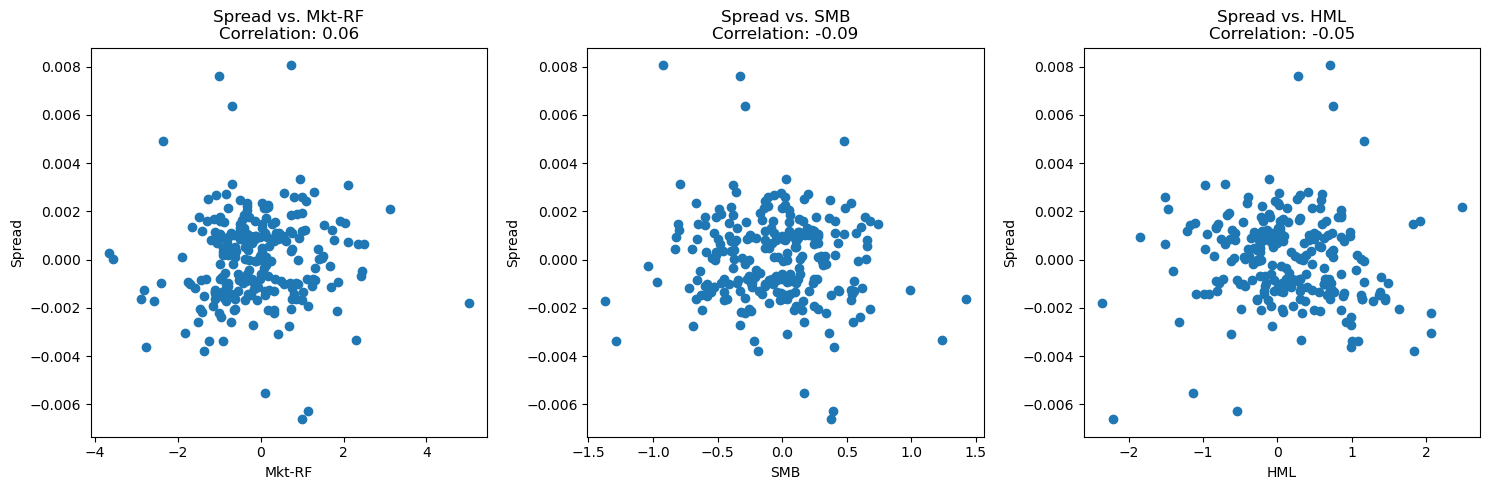

In [389]:
# Calculate correlation
correlation_matrix = merged_df[['Spread', 'Mkt-RF', 'SMB', 'HML']].corr()

# Print correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Create a subplot with 3 individual plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot 1: Spread vs. Mkt_RF
correlation_value_1 = correlation_matrix.loc['Spread', 'Mkt-RF']
axes[0].scatter(merged_df['Mkt-RF'], merged_df['Spread'])
axes[0].set_title(f'Spread vs. Mkt-RF\nCorrelation: {correlation_value_1:.2f}')
axes[0].set_xlabel('Mkt-RF')
axes[0].set_ylabel('Spread')

# Plot 2: Spread vs. SMB
correlation_value_2 = correlation_matrix.loc['Spread', 'SMB']
axes[1].scatter(merged_df['SMB'], merged_df['Spread'])
axes[1].set_title(f'Spread vs. SMB\nCorrelation: {correlation_value_2:.2f}')
axes[1].set_xlabel('SMB')
axes[1].set_ylabel('Spread')

# Plot 3: Spread vs. HML
correlation_value_3 = correlation_matrix.loc['Spread', 'HML']
axes[2].scatter(merged_df['HML'], merged_df['Spread'])
axes[2].set_title(f'Spread vs. HML\nCorrelation: {correlation_value_3:.2f}')
axes[2].set_xlabel('HML')
axes[2].set_ylabel('Spread')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Here, we can see that there is no apparent correlation between any of the farma french factors and our spread.

Correlation Matrix:
                Cumulative PNL    Mkt-RF       SMB       HML
Cumulative PNL        1.000000  0.071031 -0.074025  0.044348
Mkt-RF                0.071031  1.000000 -0.264254 -0.485196
SMB                  -0.074025 -0.264254  1.000000  0.102156
HML                   0.044348 -0.485196  0.102156  1.000000


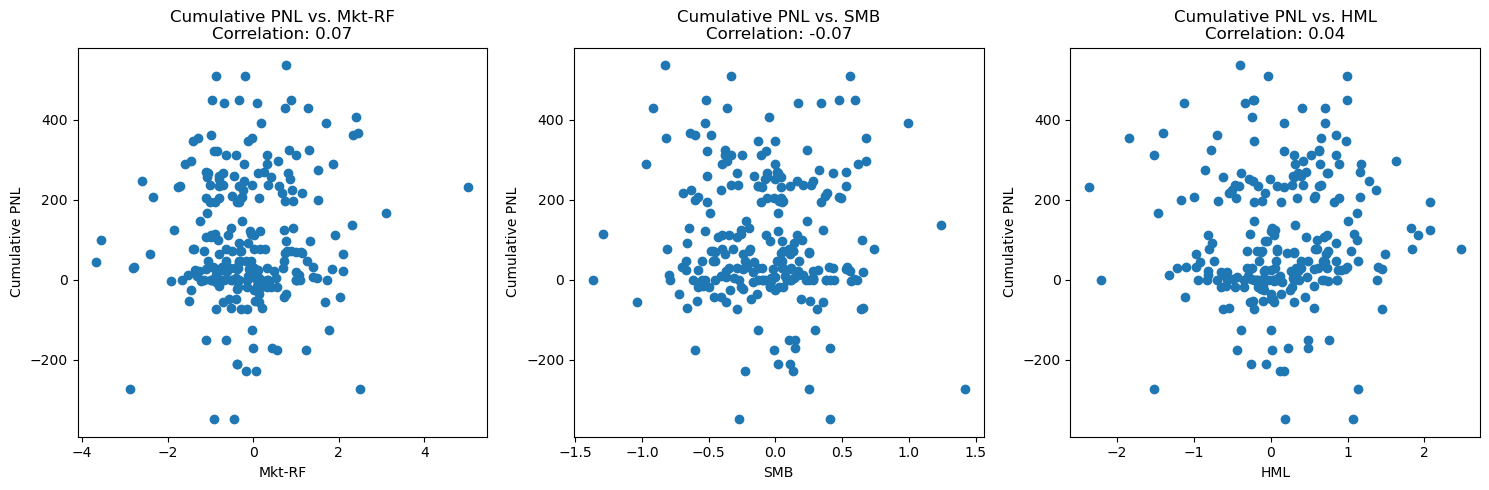

In [397]:
# Calculate correlation
correlation_matrix = merged_df[['Cumulative PNL', 'Mkt-RF', 'SMB', 'HML']].corr()

# Print correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Create a subplot with 3 individual plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot 1: Cumulative PNL vs. Mkt_RF
correlation_value_1 = correlation_matrix.loc['Cumulative PNL', 'Mkt-RF']
axes[0].scatter(merged_df['Mkt-RF'], merged_df['Cumulative PNL'])
axes[0].set_title(f'Cumulative PNL vs. Mkt-RF\nCorrelation: {correlation_value_1:.2f}')
axes[0].set_xlabel('Mkt-RF')
axes[0].set_ylabel('Cumulative PNL')

# Plot 2: Cumulative PNL vs. SMB
correlation_value_2 = correlation_matrix.loc['Cumulative PNL', 'SMB']
axes[1].scatter(merged_df['SMB'], merged_df['Cumulative PNL'])
axes[1].set_title(f'Cumulative PNL vs. SMB\nCorrelation: {correlation_value_2:.2f}')
axes[1].set_xlabel('SMB')
axes[1].set_ylabel('Cumulative PNL')

# Plot 3: Cumulative PNL vs. HML
correlation_value_3 = correlation_matrix.loc['Cumulative PNL', 'HML']
axes[2].scatter(merged_df['HML'], merged_df['Cumulative PNL'])
axes[2].set_title(f'Cumulative PNL vs. HML\nCorrelation: {correlation_value_3:.2f}')
axes[2].set_xlabel('HML')
axes[2].set_ylabel('Cumulative PNL')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Here, we can see a similar trend there is no apparent correlation between any of the farma french factors and our cumulative PNL for our best-performing strategy.

In [408]:
import statsmodels.api as sm

# Regression analysis for Cumulative PNL vs Mkt_RF
X_1 = sm.add_constant(merged_df['Mkt-RF'])
y_1 = merged_df['Cumulative PNL']
model_1 = sm.OLS(y_1, X_1).fit()

# Regression analysis for Cumulative PNL vs SMB
X_2 = sm.add_constant(merged_df['SMB'])
y_2 = merged_df['Cumulative PNL']
model_2 = sm.OLS(y_2, X_2).fit()

# Regression analysis for Cumulative PNL vs HML
X_3 = sm.add_constant(merged_df['HML'])
y_3 = merged_df['Cumulative PNL']
model_3 = sm.OLS(y_3, X_3).fit()

# Print regression results
print("Regression Results for Cumulative PNL vs Mkt_RF:")
print(model_1.summary())

print("\nRegression Results for Cumulative PNL vs SMB:")
print(model_2.summary())

print("\nRegression Results for Cumulative PNL vs HML:")
print(model_3.summary())


Regression Results for Cumulative PNL vs Mkt_RF:
                            OLS Regression Results                            
Dep. Variable:         Cumulative PNL   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.207
Date:                Thu, 01 Feb 2024   Prob (F-statistic):              0.273
Time:                        22:51:07   Log-Likelihood:                -1559.1
No. Observations:                 240   AIC:                             3122.
Df Residuals:                     238   BIC:                             3129.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

### SVOL Correlation

In [404]:
merged_df_2['Date'] = pd.to_datetime(merged_df_2['Date'])
t_svol['Date'] = pd.to_datetime(t_svol['Date'])

# Merge based on the 'Date' column
merged_df_2 = pd.merge(merged_df_2, t_svol, on='Date', how='inner')
merged_df_2

MergeError: Passing 'suffixes' which cause duplicate columns {'svol_adj_volume_x', 'svol_adj_close_x'} is not allowed.

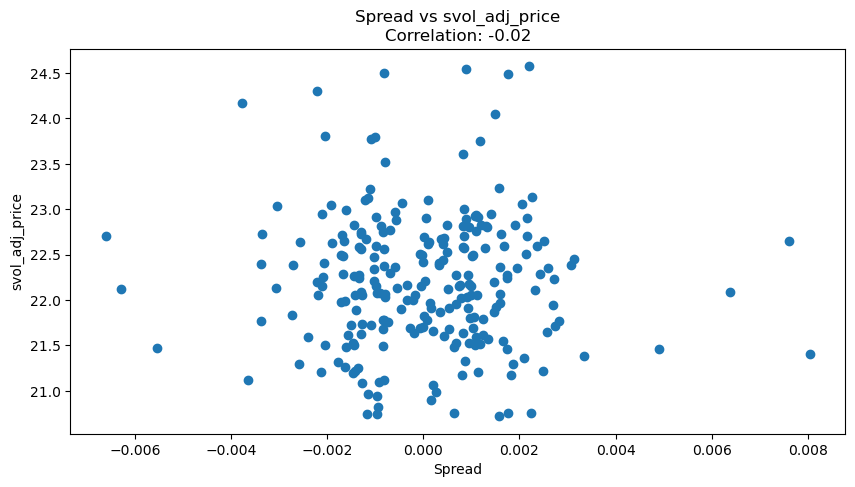

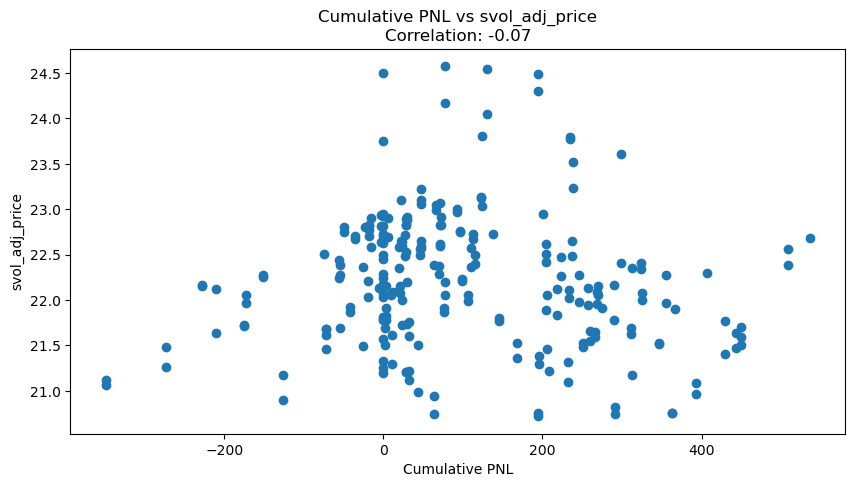

In [406]:
from scipy.stats import pearsonr

# Plot 1: Spread vs svol_adj_price
plt.figure(figsize=(10, 5))
plt.scatter(merged_df_2['Spread'], merged_df_2['svol_adj_close'])
correlation_value_1, _ = pearsonr(merged_df_2['Spread'], merged_df_2['svol_adj_close'])
plt.title(f'Spread vs svol_adj_price\nCorrelation: {correlation_value_1:.2f}')
plt.xlabel('Spread')
plt.ylabel('svol_adj_price')
plt.show()

# Plot 2: Cumulative PNL vs svol_adj_price
plt.figure(figsize=(10, 5))
plt.scatter(merged_df_2['Cumulative PNL'], merged_df_2['svol_adj_close'])
correlation_value_2, _ = pearsonr(merged_df_2['Cumulative PNL'], merged_df_2['svol_adj_close'])
plt.title(f'Cumulative PNL vs svol_adj_price\nCorrelation: {correlation_value_2:.2f}')
plt.xlabel('Cumulative PNL')
plt.ylabel('svol_adj_price')
plt.show()

In [407]:
import statsmodels.api as sm

# Regression analysis for Spread vs svol_adj_price
X_1 = sm.add_constant(merged_df_2['Spread'])
y_1 = merged_df_2['svol_adj_close']
model_1 = sm.OLS(y_1, X_1).fit()

# Regression analysis for Cumulative PNL vs svol_adj_price
X_2 = sm.add_constant(merged_df_2['Cumulative PNL'])
y_2 = merged_df_2['svol_adj_close']
model_2 = sm.OLS(y_2, X_2).fit()

# Print regression results
print("Regression Results for Spread vs svol_adj_price:")
print(model_1.summary())

print("\nRegression Results for Cumulative PNL vs svol_adj_price:")
print(model_2.summary())


Regression Results for Spread vs svol_adj_price:
                            OLS Regression Results                            
Dep. Variable:         svol_adj_close   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.09889
Date:                Thu, 01 Feb 2024   Prob (F-statistic):              0.753
Time:                        22:50:18   Log-Likelihood:                -268.64
No. Observations:                 240   AIC:                             541.3
Df Residuals:                     238   BIC:                             548.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

<h2> 5. Conclusion </h2>
<br>
In conclusion, this was a great assignment to learn how to implement a simple spread trading strategy. I learned how adjusting g, j, and trading cost multiplier could adjust my cumulative PNL over time. Additionally, I was also able to analyze my best trading strategy to determine correlationa and regression relationships between the farma french factors along with the SVOL adjusted close price. I would have liked to see a strong correlation between my spread for IDU Returns - XLU Returns and SVOL adj price, confirming that there was a difference in spread due to the volatility. 